In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Import Statsmodels
from statsmodels.tsa.ar_model import AutoReg

# We represent data with aggregated mean values for each month-year pair (44 in total), to simplify analysis
# Since 'Currency' is identical across data-set, it is not considered causally relevant so is excluded from this analysis
# Since 'Cost/Conv' is a linear function of the 'Cost' and 'Conversion' columns respectively, it is also not considered
# causally relevant so is excluded from this analysis

df = pd.read_csv("Marketing_Dataset.csv", usecols=[
                 'Day', 'Clicks', 'Cost', 'Conversions']).dropna()

df = df.replace(',', '', regex=True)

df['Clicks'] = pd.to_numeric(df['Clicks'], errors='coerce').astype('Float64')

df['Cost'] = pd.to_numeric(df['Cost'], errors='coerce').astype('Float64')

df['Conversions'] = pd.to_numeric(
    df['Conversions'], errors='coerce').astype('Float64')

df['Day'] = df['Day'].astype(str)

df['Day'] = df['Day'].apply(lambda x: x[3:10])

df = df.groupby(["Day"]).mean()

df_monthly = df.copy()

df_monthly.reset_index(inplace=True)

df_monthly = df_monthly.rename(columns={'Day': 'Date'})

df_monthly['Date'] = pd.to_datetime(
    df_monthly['Date'], format="%m/%Y").dt.strftime('%y-%m')

df_monthly = df_monthly.sort_values('Date').reset_index(drop=True)

df_monthly = df_monthly.set_index('Date')

df = df_monthly

print(df)

print(df.shape)

             Clicks          Cost  Conversions
Date                                          
17-07    660.896552   1893.293793    81.586207
17-08   1100.193548   3270.934839   167.290323
17-09  13064.466667   2495.859333        681.8
17-10  12438.516129   2132.414194    938.83871
17-11  10151.933333      2150.262   767.066667
17-12   4580.322581   2054.171613   238.129032
18-01  11874.580645   2561.670323   777.225806
18-02  16731.357143   3252.685714   914.357143
18-03  10599.935484   3494.432258   773.032258
18-04   5604.066667   2992.085333   478.933333
18-05   8145.290323   4141.916774   602.516129
18-06   6627.266667   6444.395333   882.933333
18-07   8300.322581   6284.162581   864.193548
18-08  10868.258065   7658.639355  1144.580645
18-09   8595.933333   9274.030667  1139.666667
18-10   9239.354839   8538.112903  1115.483871
18-11        8900.0     12604.924  1590.266667
18-12  10361.096774  17634.225161  2007.096774
19-01  12041.225806  18095.160645  2117.677419
19-02  16662.

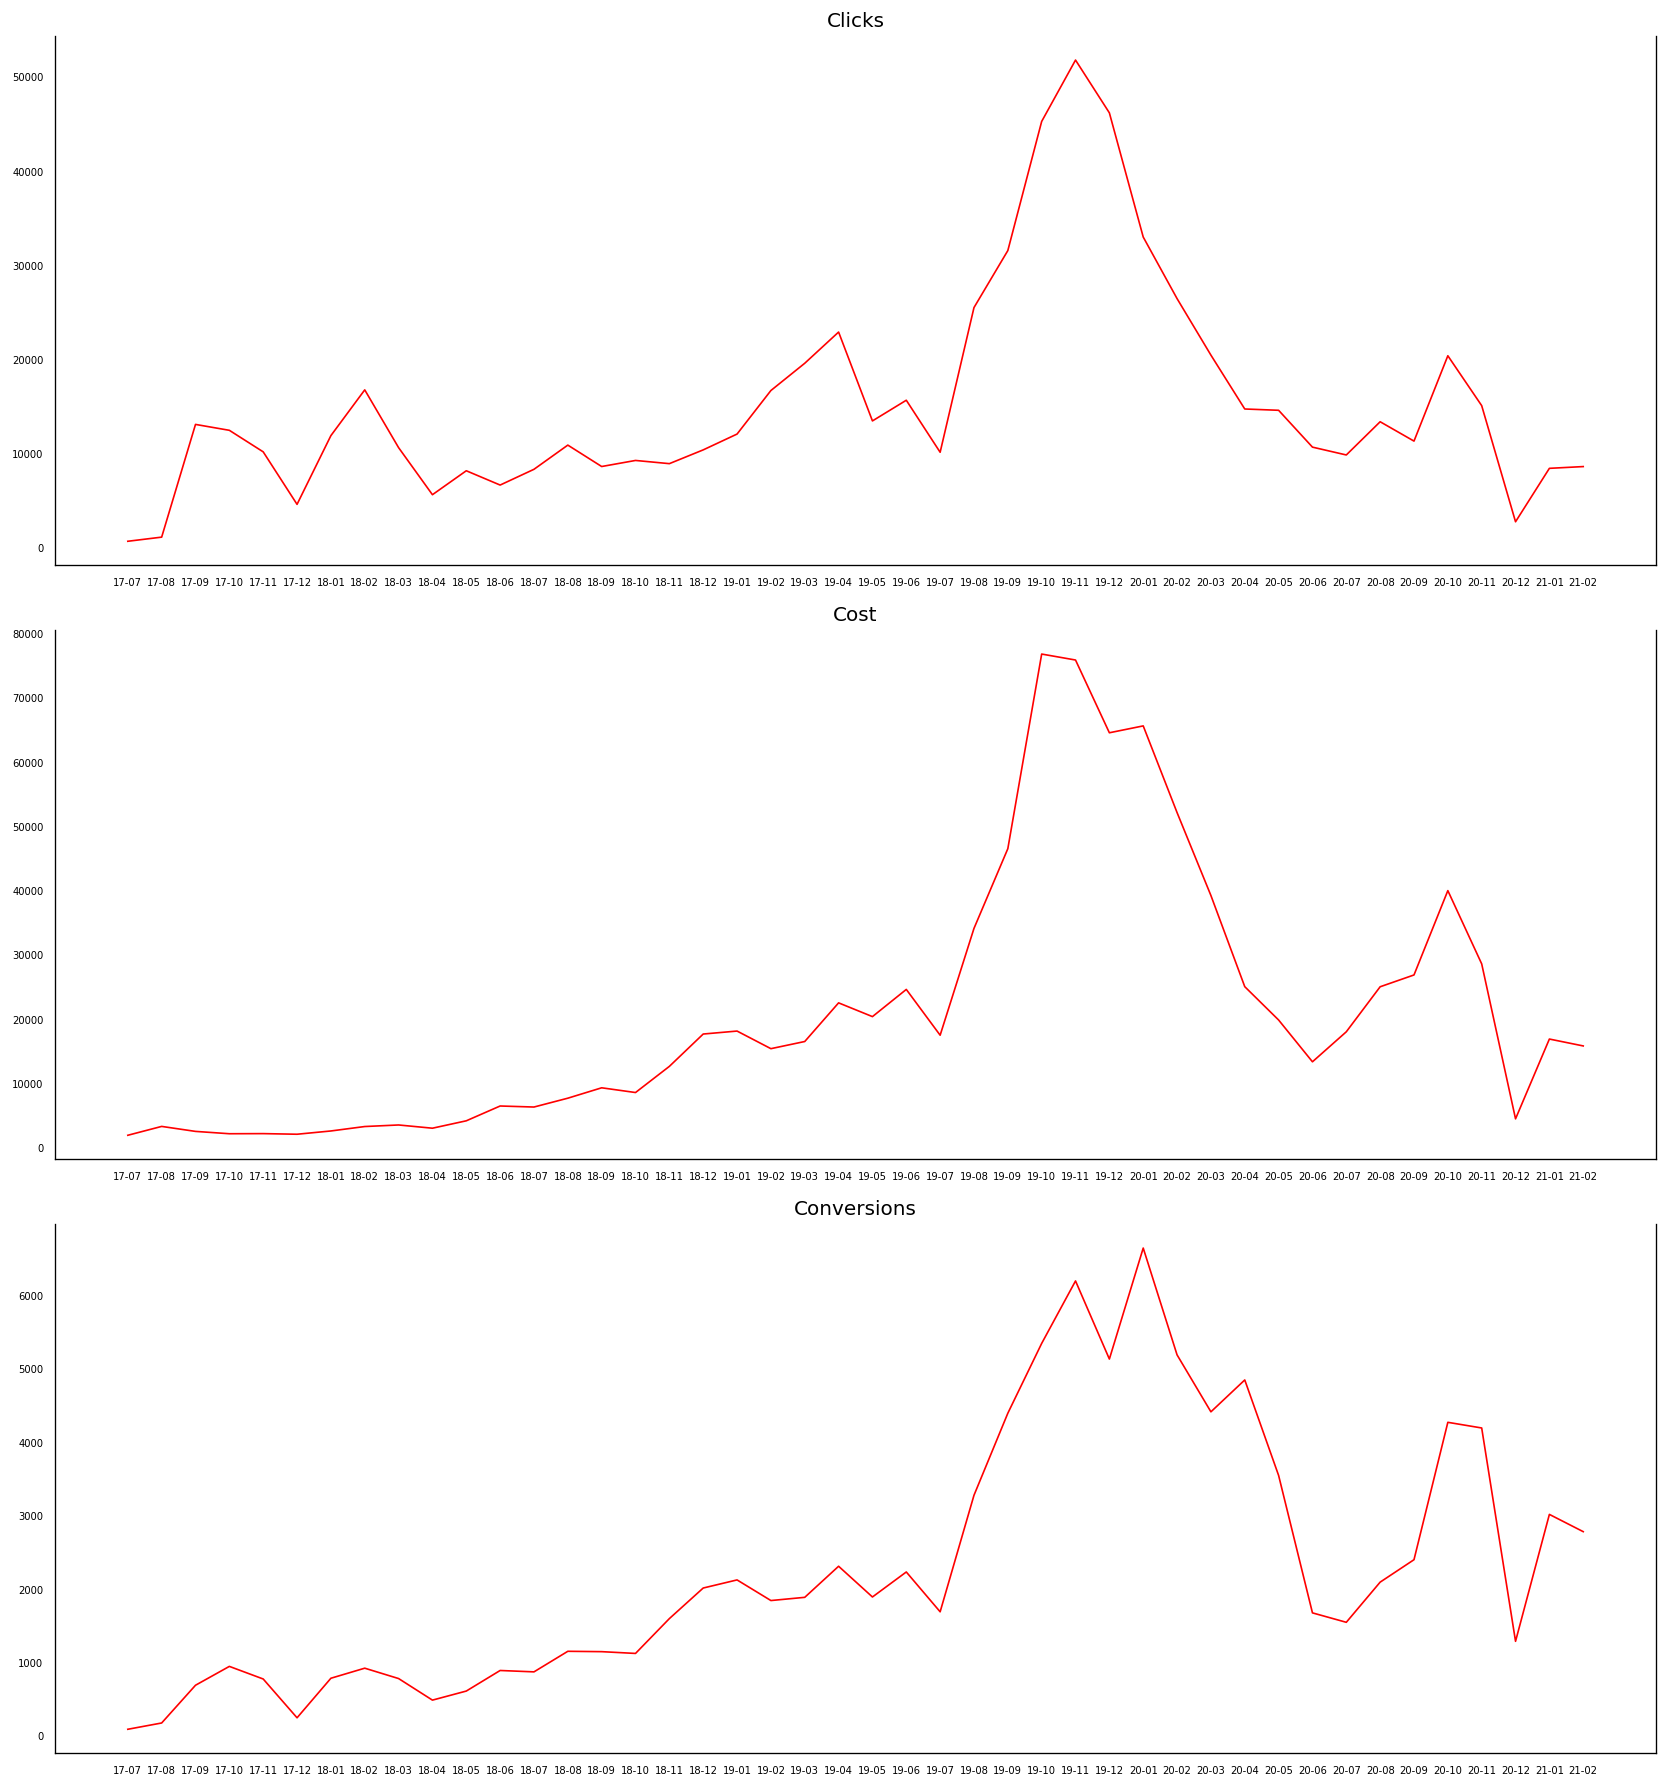

In [15]:
# Plotting the time-series
# At first glance, Clicks, Cost and Conversions appear to move quite similarly 
# The next step is to formally check for statistically significant relationships between the respective time-series
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(14,15))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [16]:
# This cointegration test will determine whether there is a long-run, statistically significant relationship between the 
# respective time-series

# The results show that there actually isn't, at least not demonstrably from the data presented, meaning we choose to forecast
# conversions using an Autoregression instead of a Vector Autoregression

# What this essentially means is that we will project Conversions solely using its own lagged values as variables, instead
# of also using Clicks and Cost also as variables 

df_copy = df.copy()
df_copy['Clicks'] = df_copy['Clicks'].apply(np.int64)
df_copy['Cost'] = df_copy['Cost'].apply(np.int64)
df_copy['Conversions'] = df_copy['Conversions'].apply(np.int64)

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df_copy, alpha=0.05): 
    out = coint_johansen(df_copy,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df_copy.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_copy)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Clicks ::  11.41     > 24.2761   =>   False
Cost   ::  3.82      > 12.3212   =>   False
Conversions ::  0.17      > 4.1296    =>   False


In [17]:
# Check for stationarity (ie. are the statistical properties constant over time?) of the Conversions time-series
# P-Value > 0.05, and test statistic is more than any of the critical values, so we conclude that the Conversions time-series is
# non-stationary

df_conversions = df.copy()
del df_conversions['Clicks']
del df_conversions['Cost']

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df_conversions, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. # of Lags : ", dftest[2])
print("4. # of Observations used for ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.9673224426559843
2. P-Value :  0.30108224739060757
3. # of Lags :  0
4. # of Observations used for ADF Regression and Critical Values Calculation : 43
5. Critical Values :
	 1% :  -3.5925042342183704
	 5% :  -2.931549768951162
	 10% :  -2.60406594375338


1. ADF :  -3.449678905443818
2. P-Value :  0.009377498555921217
3. # of Lags :  0
4. # of Observations used for ADF Regression and Critical Values Calculation : 43
5. Critical Values :
	 1% :  -3.5925042342183704
	 5% :  -2.931549768951162
	 10% :  -2.60406594375338


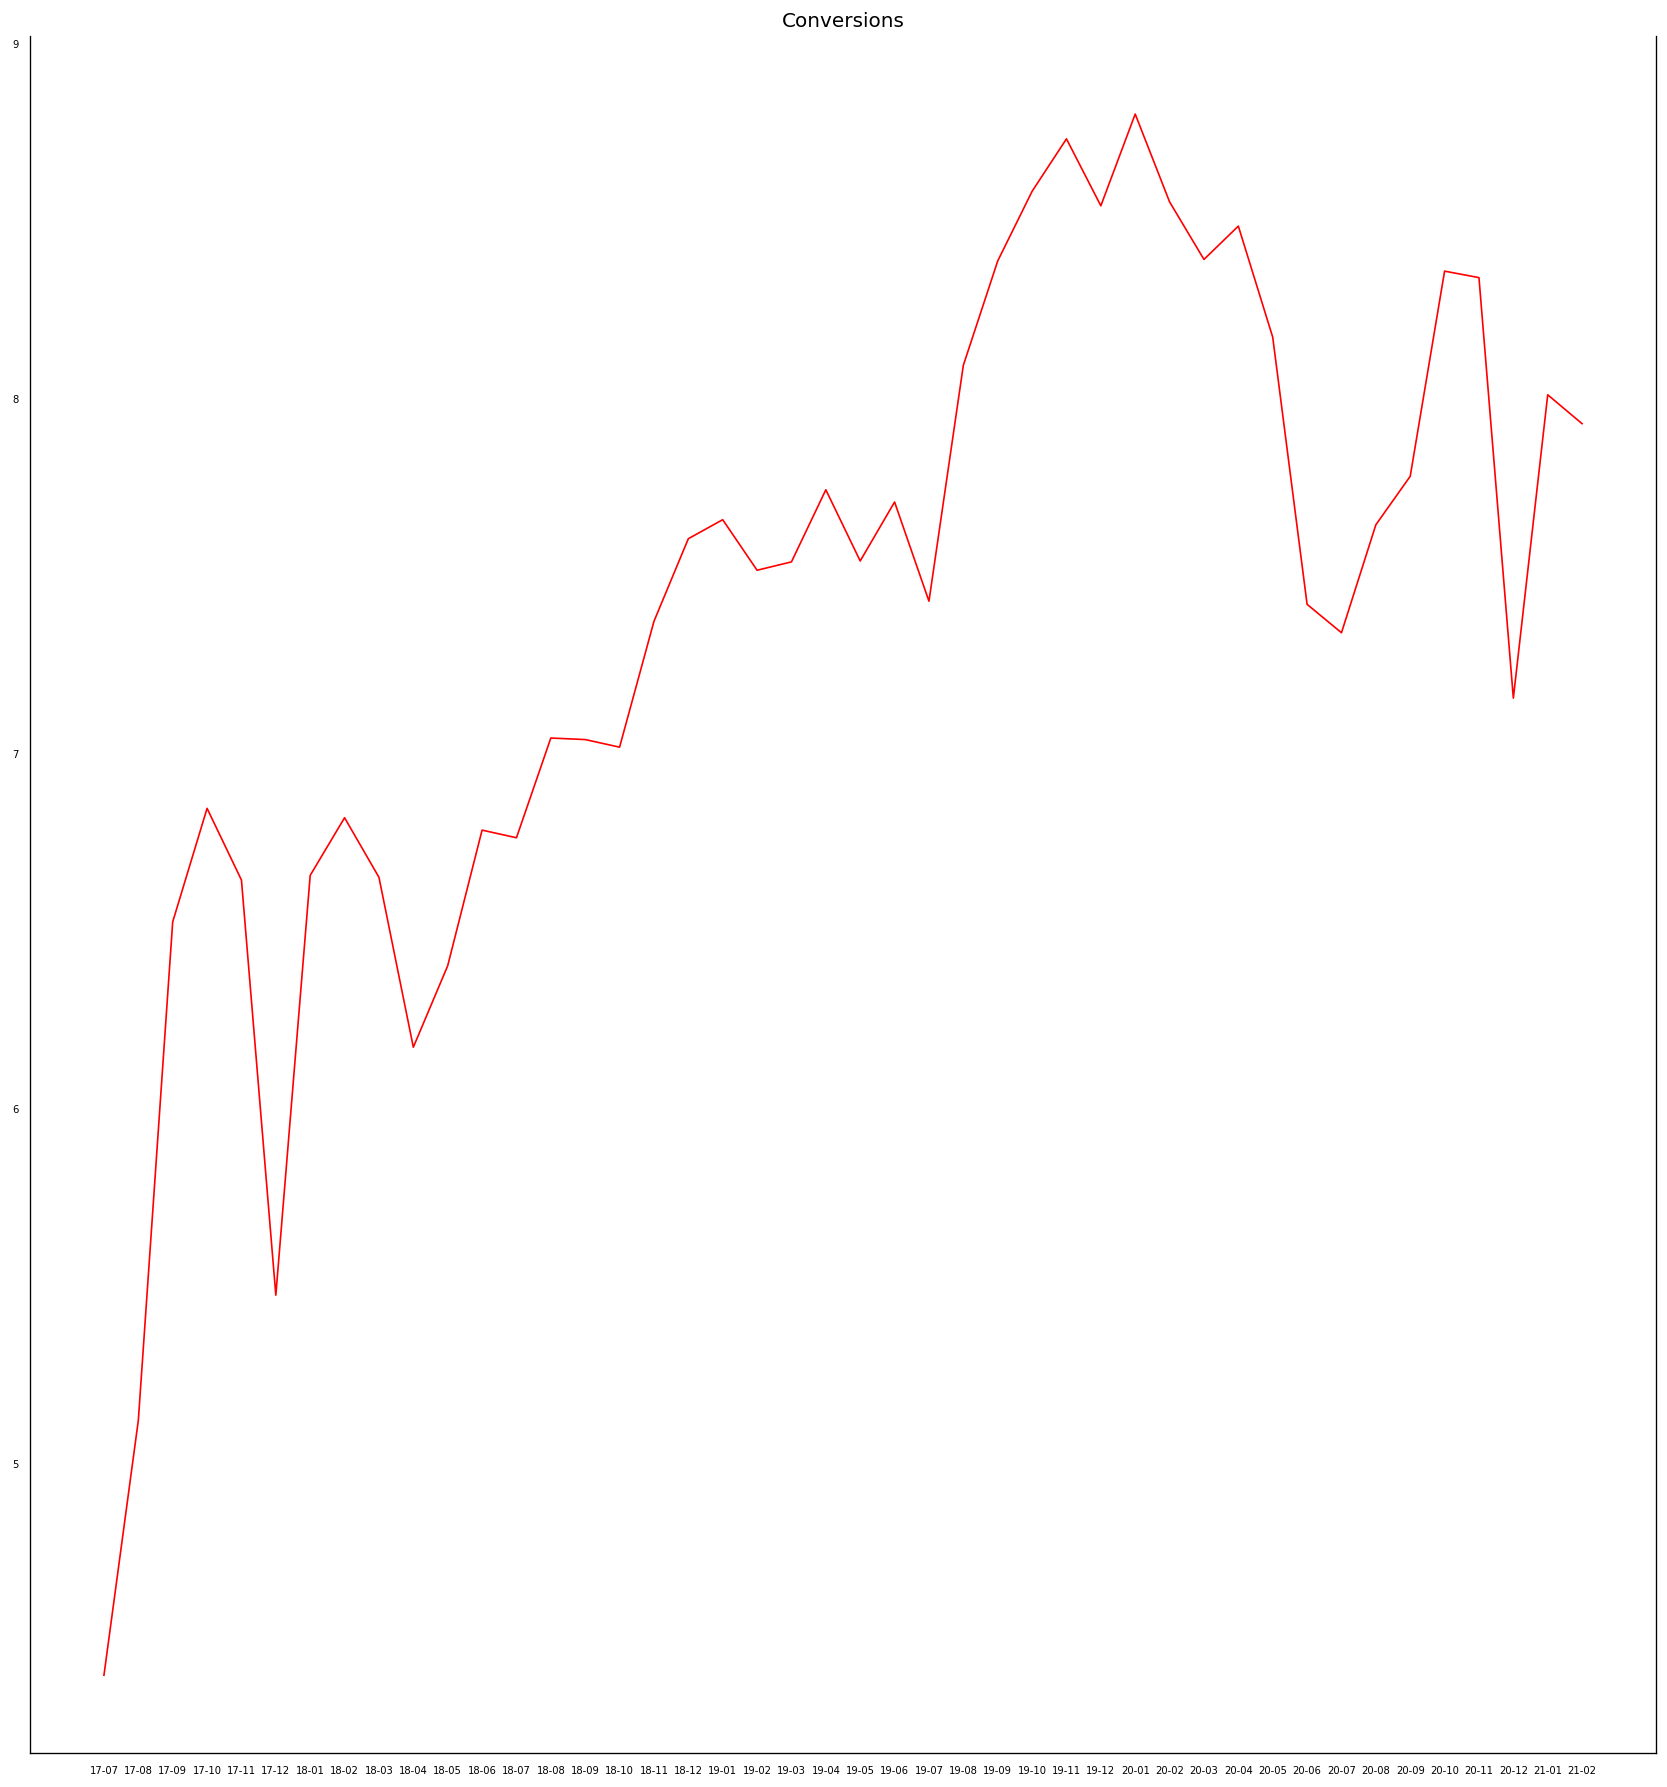

In [18]:
# By transforming the Conversions times-series through taking logs, we now achieve stationarity; plot is presented
# Other transformations were considered, however taking logs yielded a lower RMSE

# Difference Transformations
# df_conversions_1 = df_conversions.diff().dropna()
# df_conversions_1 = (df_conversions.diff().dropna()).diff().dropna()
# df_conversions_1 = ((df_conversions.diff().dropna()).diff().dropna()).diff().dropna()

# Log Transformations
df_conversions_1 = np.log(df_conversions)
# df_conversions_1 = (np.log(df_conversions)).diff().dropna()
# df_conversions_1 = ((np.log(df_conversions)).diff().dropna()).diff().dropna()
# df_conversions_1 = (((np.log(df_conversions)).diff().dropna()).diff().dropna()).diff().dropna()

# Square Root Transformations
# df_conversions_1 = np.sqrt(df_conversions)
# df_conversions_1 = (np.sqrt(df_conversions)).diff().dropna()
# df_conversions_1 = ((np.sqrt(df_conversions)).diff().dropna()).diff().dropna()
# df_conversions_1 = (((np.sqrt(df_conversions)).diff().dropna()).diff().dropna()).diff().dropna()

# Proportional Change Transformations
# df_conversions_1 = (df_conversions.shift(1)/df_conversions).dropna()
# df_conversions_1 = ((df_conversions.shift(1)/df_conversions).dropna()).diff().dropna()
# df_conversions_1 = (((df_conversions.shift(1)/df_conversions).dropna()).diff().dropna()).diff().dropna()
# df_conversions_1 = ((((df_conversions.shift(1)/df_conversions).dropna()).diff().dropna()).diff().dropna()).diff().dropna()

dftest1 = adfuller(df_conversions_1, autolag = 'AIC')

print("1. ADF : ",dftest1[0])
print("2. P-Value : ", dftest1[1])
print("3. # of Lags : ", dftest1[2])
print("4. # of Observations used for ADF Regression and Critical Values Calculation :", dftest1[3])
print("5. Critical Values :")
for key, val in dftest1[4].items():
    print("\t",key, ": ", val)
    
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(14,15))
data = df_conversions_1['Conversions']
axes.plot(data, color='red', linewidth=1)
axes.set_title(df.columns[i])
axes.xaxis.set_ticks_position('none')
axes.yaxis.set_ticks_position('none')
axes.spines["top"].set_alpha(0)
axes.tick_params(labelsize=6)

plt.tight_layout();

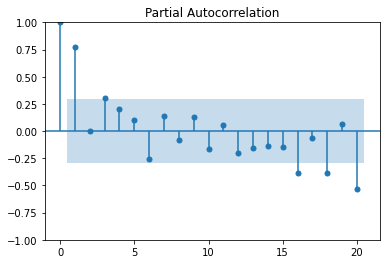

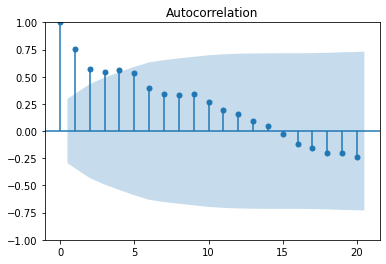

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
pacf = plot_pacf(df_conversions_1['Conversions'], lags = 20)
acf = plot_acf(df_conversions_1['Conversions'], lags = 20)

# Partial autocorrelation gets choppy after 5, so we will consider 5 lagged variables at most for our regression

# Autocorrelation gives us a sense of how correlated lagged values of Conversions are to present values
# Since Partial Autocorrelation indicates the direct effect of the lagged variable to the present value, whereas Autocorrelation
# takes into account indirect effects too, we assess Partial Autocorrelation when considering how many lagged variables we wish
# to include in our regression

In [21]:
# Split time-series into training and testing sets; all apart from the last 7 observations will be split into training
# Then, we train the model and assess its parameters; we respecify the model accordingly to minimise the P>|z| values

X = df_conversions_1.values
train = X[:len(X)-7]
test = X[len(X)-7:]

model = AutoReg(train, lags = 4).fit()

print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   37
Model:                     AutoReg(4)   Log Likelihood                 -11.809
Method:               Conditional MLE   S.D. of innovations              0.346
Date:                Mon, 27 Jun 2022   AIC                             35.617
Time:                        23:37:52   BIC                             44.596
Sample:                             4   HQIC                            38.638
                                   37                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9934      0.570      1.744      0.081      -0.123       2.110
y.L1           0.6894      0.161      4.292      0.000       0.375       1.004
y.L2          -0.0216      0.198     -0.109      0.9

[7.70018947 7.92587251 7.85332375 7.74065504 7.75270859 7.83848133
 7.88587418]

Root mean squared error = 0.383098276921811


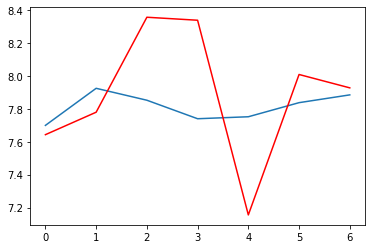

In [22]:
# Based off the above model, we make predictions on the test set and compare to actual observations
# The blue line represents the predictions of our model, the red line represents the testing set's actual observations 
# We also calculate the root mean squared error, which is the standard deviation of the residuals; the lower the value, the 
# better "fitted" this model is to the dataset

pred = model.predict(start = len(train), end = len(X) - 1, dynamic = False)

plt.plot(pred)
plt.plot(test, color = 'red')
print(pred)

# Calculate error 

import sklearn
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test, pred))

print("")
print("Root mean squared error =",rmse)

In [23]:
# Making future predictions

pred_future = model.predict(start = len(X) + 1, end = len(X) + 10, dynamic = False)
print("The future prediction for the rest of 2021")
print(pred_future)
print("Number of predictions made: \t", len(pred_future))

The future prediction for the rest of 2021
[7.87310123 7.88896467 7.91482926 7.93176657 7.93887321 7.94580123
 7.95667454 7.96848439 7.9778968  7.98521539]
Number of predictions made: 	 10


In [24]:
# Invert data back to pre-transformed state, for final predictions
# Since we used logs to transform the dataset, we take exponents to invert it back

inv_pred_future = np.exp(pred_future)

print(inv_pred_future)

[2625.69586819 2667.68055546 2737.57907324 2784.341204   2804.19899064
 2823.69396989 2854.5644199  2888.47625189 2915.79210756 2937.20987903]


          Forecast
Month             
21-03  2625.695868
21-04  2667.680555
21-05  2737.579073
21-06  2784.341204
21-07  2804.198991
21-08  2823.693970
21-09  2854.564420
21-10  2888.476252
21-11  2915.792108
21-12  2937.209879


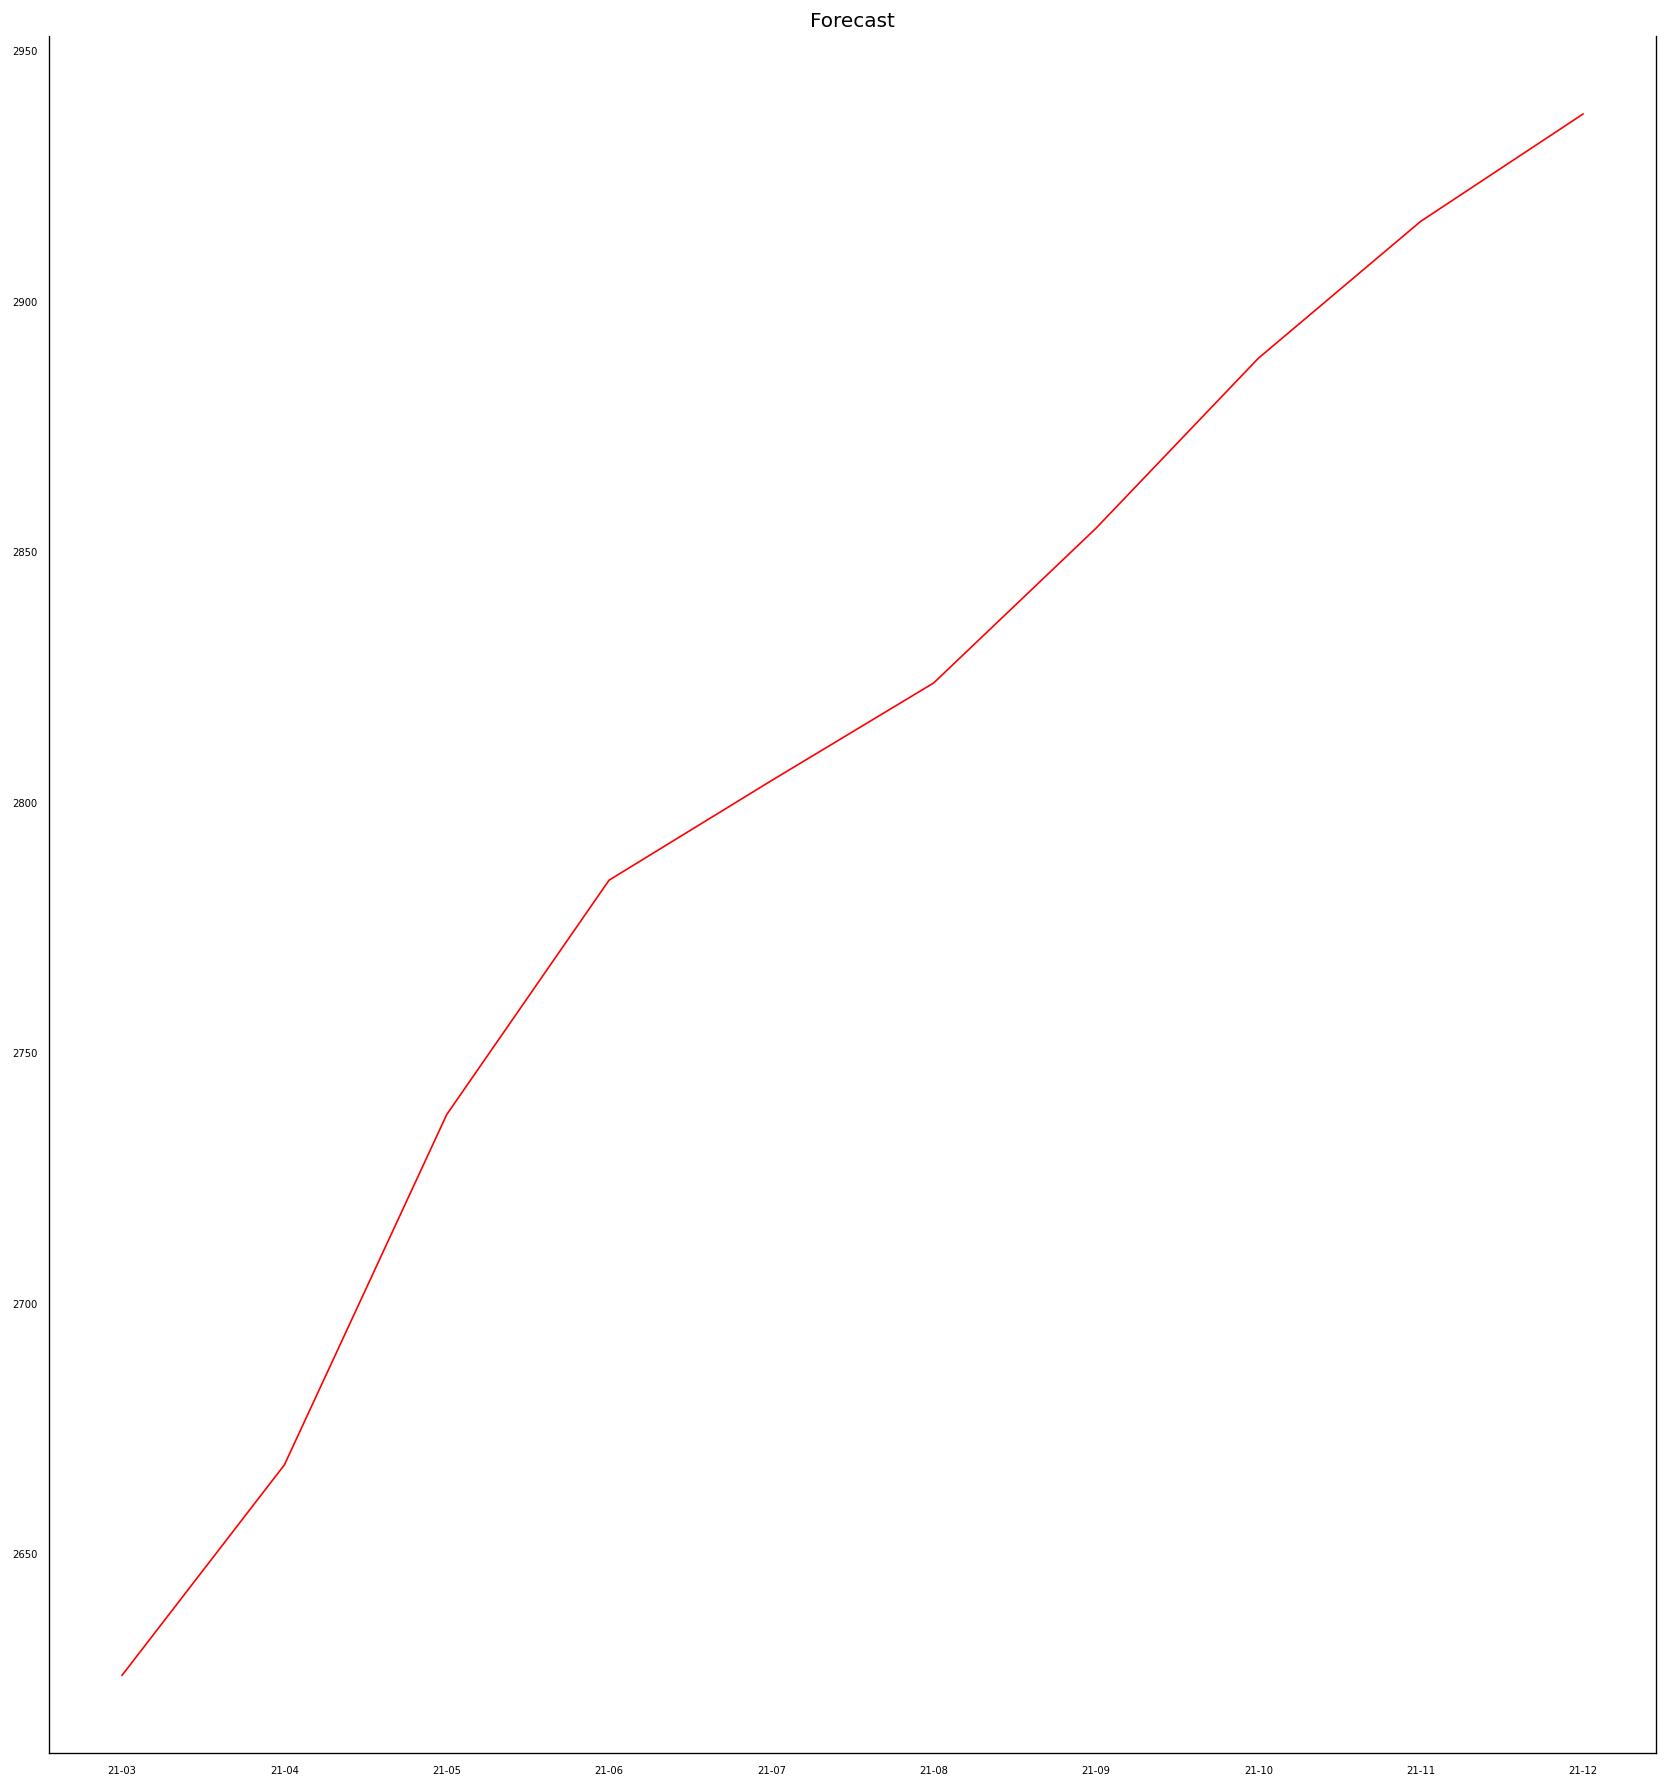

In [25]:
# Below is the set of forecasts for the rest of 2021, also plotted

forecast_date = pd.date_range(start='2021-03', freq='MS', periods=10).astype(str)

forecast_full = pd.DataFrame(inv_pred_future, forecast_date)

forecast_full.reset_index(inplace=True)

forecast_full.columns = ['Month', 'Forecast']

forecast_full['Month'] = pd.to_datetime(
    forecast_full['Month'], format="%Y-%m-%d").dt.strftime('%y-%m')

forecast_full = forecast_full.set_index('Month')

print(forecast_full)

fig, axes = plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(14,15))
data = forecast_full['Forecast']
axes.plot(data, color='red', linewidth=1)
axes.set_title('Forecast')
axes.xaxis.set_ticks_position('none')
axes.yaxis.set_ticks_position('none')
axes.spines["top"].set_alpha(0)
axes.tick_params(labelsize=6)

plt.tight_layout();